# Non-Parametric-Learners

## kNN and Decision Trees

### Jonathan Torrez
#### January 30, 2017

*CREDITS (based on the notes and slides of Ryan Henning, Giovanna Thron, and Cary Goltermann)*

## Lecture Objectives [morning-kNN]

* **Describe** difference betwween parametric and non-parametric learning
* **Describe** pros and cons of parametric and non-parametric learning
* **Explain** one analogy demonstrating basic intuition of kNN algorithm
* **Implement** pseudocode for kNN algorithm
* **Describe** effect of varying k (num_neigbors)
    * bias-variance tradeoff
* **Explain** importance of scaling for kNN
* **State** common distance metrics used for kNN
* **Describe** curse of dimensionality
* **Explain** one analogy describing curse of dimensionality
* **Describe** pros and cons of kNN algorithm
* **Describe** variants of basic kNN algorithm
* **State** use case for kNN

## Parametric vs. Non-Parametric Models


### Parametric Models

#### Linear Regression


$$\hat y = \hat\beta_0 + \hat\beta_1 X_1 + \hat\beta_2 X_2 + ... + \hat\beta_i X_i $$
    
How many parameters can we describe it with?

Can we ever change the number of parameters?

## Properties of Parametric Models

1. Assumes an underlying form in the data.
2. Number of parameters needed to describe that form is ***fixed.***

#### Examples:
* Linear regression
* Logistic regression


## Properties of Non-Parametric Models

Class discussion: What do you think they are?

In [1]:
# load answers after class discussion
with open('answers/prop_non_param.txt') as f:
    for line in f:
        print line

1. Makes no strong assumptions about the underlying form of the data.

    * Let's the data speak for itself

2. Describes the form of the data with a (potentially) infinite number of parameters.



Class discussion: contrast the pros and cons of these two types of models

## Pros-Cons of Parametric Models

In [2]:
# load answers after class discussion
with open('answers/pc_param.txt') as f:
    for line in f:
        print line

Pros:

-----

1. Simpler:

    * Easier to understand and interpret results

2. Less data:

    * Don't require as much training data (since you assume a form)

Cons:

-----

1. Strong Assumptions:

    * By assuming a form, data must match that form for a good fit

2. Limited Complexity:

    * Number of parameters to describe data is fixed

    * Could fail to match the signal of the data



## Pros-Cons of Non-parametric Models

In [3]:
# load answers after class discussion
with open('answers/pc_nonparam.txt') as f:
    for line in f:
        print line

Pros:

-----

1. Flexibility:

    * Can conform to many different (and exotic) signals in the data

2. No (or Weak) Assumptions:

    * Let's the data's form speak for itself

Cons:

-----

1. More Data:

    * Needs a lot of training data to find signal

2. Complexity:

    * Tendency to overfit since it takes exact form of data

    * Hard to explain and interpret results



In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import operator

# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
np.random.seed(12345)

In [5]:
# Make some fake data

horse_weight = np.random.rand(100) * 1500.0 + 400.0      # lbs
horse_height = horse_weight/370 + np.random.normal(0, 0.5, horse_weight.shape) + 2  # ft

dog_weight = np.random.rand(40) * 500.0 + 10.0      # lbs
dog_height = dog_weight/300 + np.random.normal(0, 0.3, dog_weight.shape) + 0.5  # ft

In [6]:
def plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height):
    """Plot the horse dog data"""
    plt.plot(horse_weight, horse_height, 'ro', label='Horse')
    plt.plot(dog_weight, dog_height, 'bo', label='Dog')
    plt.title("Horse vs Dog")
    plt.xlabel("Weight (lbs)")
    plt.ylabel("Height (ft)")
    plt.legend(loc='upper left')
    plt.show()

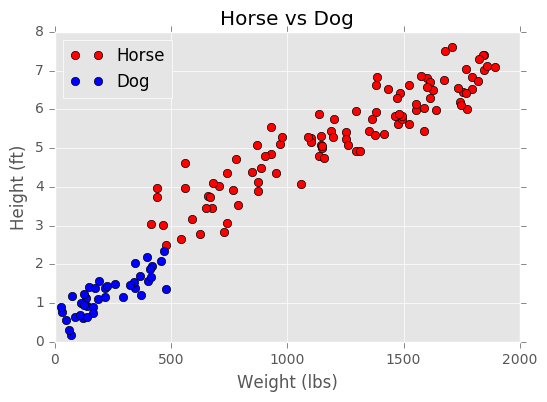

In [7]:
plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height)

## What if we get new data? 

In [8]:
new_weights = [200, 500, 1200]
new_heights = [0.7, 2.5, 5.7]

## Are they horses or dogs?

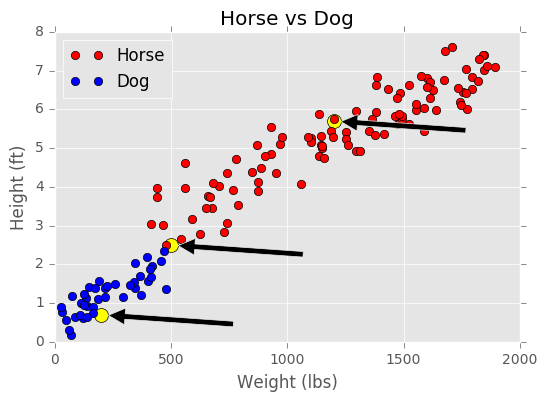

In [9]:
# Plot the new points
plt.plot(new_weights, new_heights, marker='o', markersize=10, color="yellow", linestyle='None')

# Draw arrows highlighting the new points
for new_x, new_y in zip(new_weights, new_heights):
    plt.annotate("",
                xy=(new_x, new_y), xycoords='data',
                xytext=(100, -7), textcoords='offset points',
                arrowprops=dict(facecolor='black', shrink=0.05))
    
# Plot the original data
plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height)


## What algorithm did you use?

Class discussion

## kNN pseudocode

Class discussion: What do you think this is? Describe both the training and prediction phases.

In [10]:
# load answers after class discussion
with open('answers/knn_pseudocode.txt') as f:
    for line in f:
        print line

func Train:

    save the data

func Predict:

    for data point in training set:

        calculate distance from data point to new_value

    Order distances in increasing order and take the first k data points

    Return the label with most votes



## Picking k

<img src="./images/knn_simple.png" width=500 align="left"/>

### What is the prediction if k = 3?

### What is the prediction if k = 6?

In [11]:
# Make some data that isn't quite as nice
# Not good style to write a function that takes no input, but I want to take multipe samples later so laziness wins
def make_ugly_data():
    """Return sample of horse dog data that overlaps
    
    Parameters
    ----------
    None
    
    Returns
    -------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
    """
    horse_weight = np.random.rand(50) * 1500.0 + 400.0      # lbs
    horse_height = horse_weight/370 + np.random.normal(0, 0.5, horse_weight.shape) + 2  # ft

    dog_weight = np.random.rand(30) * 800.0 + 10.0      # lbs
    dog_height = dog_weight/300 + np.random.normal(0, 0.5, dog_weight.shape) + 1  # ft
    return horse_weight, horse_height, dog_weight, dog_height

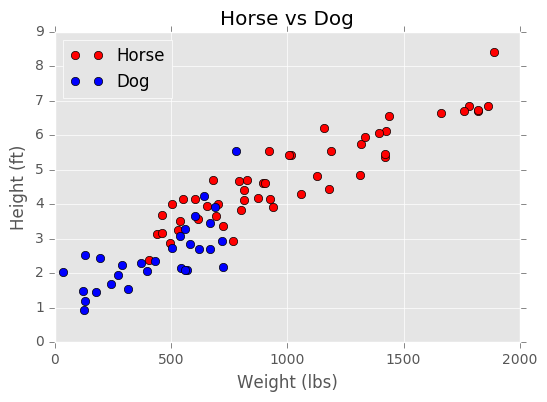

In [12]:
horse_weight, horse_height, dog_weight, dog_height = make_ugly_data()
# Plot the nastier data so we can make sure it actually overlaps
plot_horse_dog_data(horse_weight, horse_height, dog_weight, dog_height)

In [13]:
def prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height):
    """Return horse dog data in format for kNN classification
    
    Parameters
    ----------
    horse_weight: numpy array
        The weights of the horses
    horse_height: numpy array
        The height of the horses
    dog_weight: numpy array
        The weight of the dogs
    dog_height: numpy array
        The height of the dogs
        
    Returns
    -------
    X: numpy array, shape = [n_samples, 2]
        The features (weight, height) of the data
    y: numpy array, shape = [n_samples,]
        The labels for our classification (horse=0, dog=1)
    """
    X = np.column_stack((np.concatenate((horse_weight, dog_weight)),
                         np.concatenate((horse_height, dog_height))))
    y = np.concatenate((np.zeros(horse_weight.shape),
                        np.ones(dog_weight.shape)))
    return X, y

In [14]:
# Function to make getting new samples for model input easier, laziness always wins
def get_new_ugly_sample():
    """Return new sample ready for modeling
    
    Combines make_ugly_data and prep_data_for_model, see the docs for those functions
    """
    horse_weight, horse_height, dog_weight, dog_height = make_ugly_data()
    X, y = prep_data_for_model(horse_weight, horse_height, dog_weight, dog_height)
    return X, y

In [15]:
def plot_mult_decision_boundary(ax, X, y, k, scaled=True, title='Title', xlabel='xlabel', ylabel='ylabel'):
    """Plot the decision boundary of a kNN classifier.
    
    Builds and fits a sklearn kNN classifier internally.

    X must contain only 2 continuous features.

    Function modeled on sci-kit learn example.

    Parameters
    ----------
    ax: Matplotlib axes object
        The plot to draw the data and boundary on
        
    X: numpy array
        Training data
    
    y: numpy array
        Target labels
    
    k: int
        The number of neighbors that get a vote.
        
    scaled: boolean, optional (default=True)
        If true scales the features, else uses features in original units
    
    title: string, optional (default = 'Title')
        A string for the title of the plot
    
    xlabel: string, optional (default = 'xlabel')
        A string for the label on the x-axis of the plot
    
    ylabel: string, optional (default = 'ylabel')
        A string for the label on the y-axis of the plot
    

    Returns
    -------
    None
    """
    x_mesh_step_size = 0.5
    y_mesh_step_size = 0.05
    
    #Hard code in colors for classes, one class in red, one in blue
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    #Build a kNN classifier
    clf = neighbors.KNeighborsClassifier(n_neighbors=k, weights='uniform')
    
    if scaled:
        #Build pipeline to scale features
        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X, y)
    else:
        clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    feature_1 = X[:, 0]
    feature_2 = X[:, 1]
    x_min, x_max = feature_1.min() - 1, feature_1.max() + 1
    y_min, y_max = feature_2.min() - 1, feature_2.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, x_mesh_step_size),
                         np.arange(y_min, y_max, y_mesh_step_size))
    dec_boundary = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    dec_boundary = dec_boundary.reshape(xx.shape)
    ax.pcolormesh(xx, yy, dec_boundary, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(feature_1, feature_2, c=y, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    ax.set_title(title + ", k={0}, scaled={1}".format(k, scaled))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [16]:
# Get a sample to plot
X, y = get_new_ugly_sample()

In [17]:
# Save some titles and labels to make our plots pretty
title = 'Horse vs. Dog'
xlabel = 'Weight (lbs)'
ylabel = 'Height (ft)'

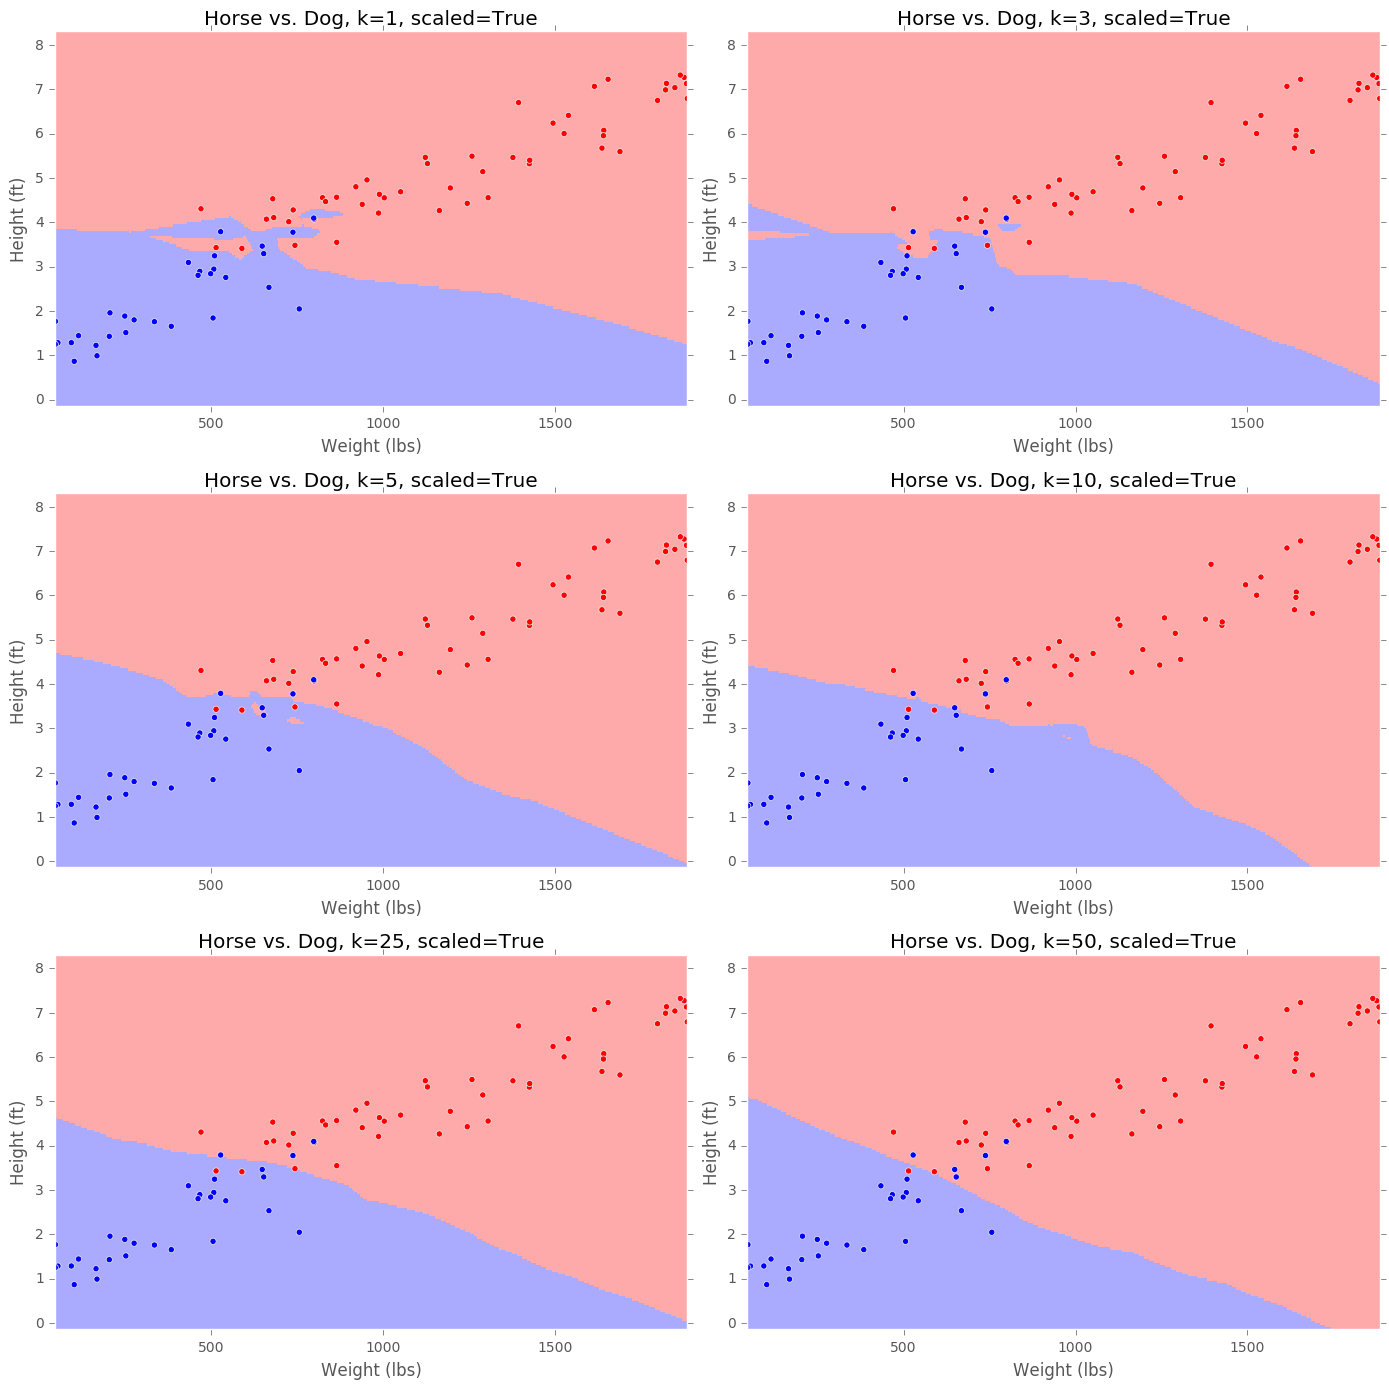

In [18]:
some_ks = [1, 3, 5, 10, 25, 50]

# Building my plot, 3 rows x 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
 
# Loop through the possible ks, put each decision boundary a separate axes
for k, ax in zip(some_ks, axs.flatten()):
    plot_mult_decision_boundary(ax, X, y, k=k, title=title, xlabel=xlabel, ylabel=ylabel)

# Keep things from overlapping
plt.tight_layout()
# Show me the money
plt.show()

### k start

In general, a good starting point for k is $$\sqrt{n}$$

## Bias-Variance

Class discussion: How does changing k affect each? Why?

### Bias

In [19]:
# load answers after class discussion
with open('answers/bias_knn.txt') as f:
    for line in f:
        print line

As k increases, bias increases.

    Strands data points in other classes' territory

As k decreases, bias decreases.

    Creates islands for strange outliers

    Perfectly fits every point



### Variance

In [20]:
# load answers after class discussion
with open('answers/variance_knn.txt') as f:
    for line in f:
        print line

As k increases, variance decreases.

    More generalizable, majority votes win.

    Decision boundary stays consistent from sample to sample.

As k decreases, variance increases.

    Decision boundary will vary significantly based on sample.



In [21]:
# Take 4 different samples from the same population and save them in a list
samples_from_same_pop = []

for _ in xrange(4):
    sample = get_new_ugly_sample()
    samples_from_same_pop.append(sample)

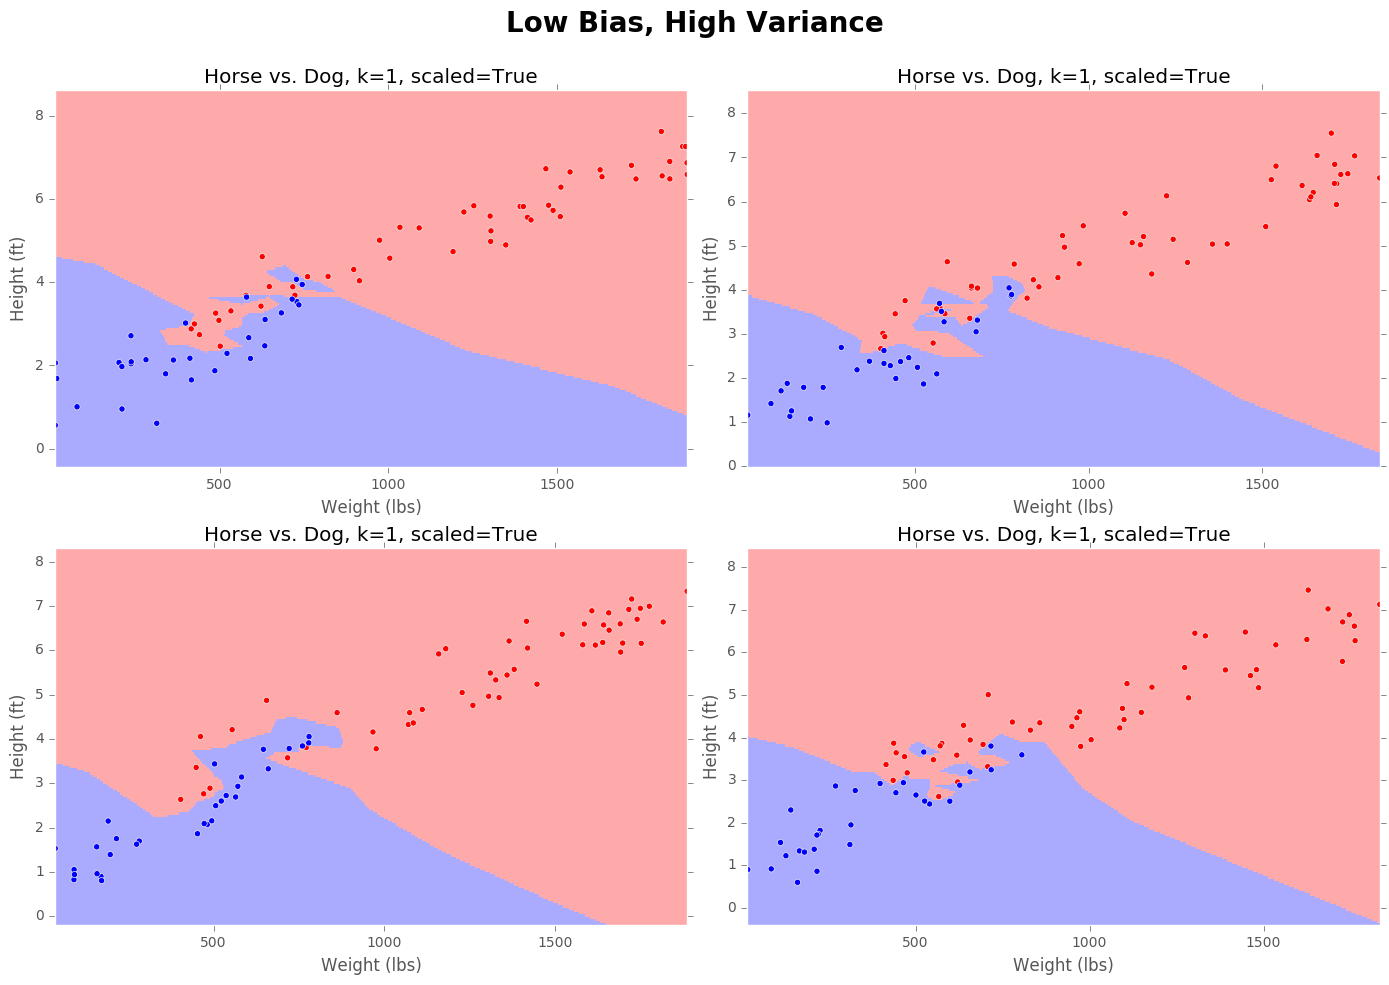

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for sample, ax in zip(samples_from_same_pop, axs.flatten()):
    X = sample[0]
    y = sample[1]
    plot_mult_decision_boundary(ax, X, y, k=1, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
# Offset the figure title to make it look nice
plt.subplots_adjust(top=0.9)
# Set a title for the entire figure
plt.suptitle('Low Bias, High Variance', fontsize=20, weight='bold')
plt.show()

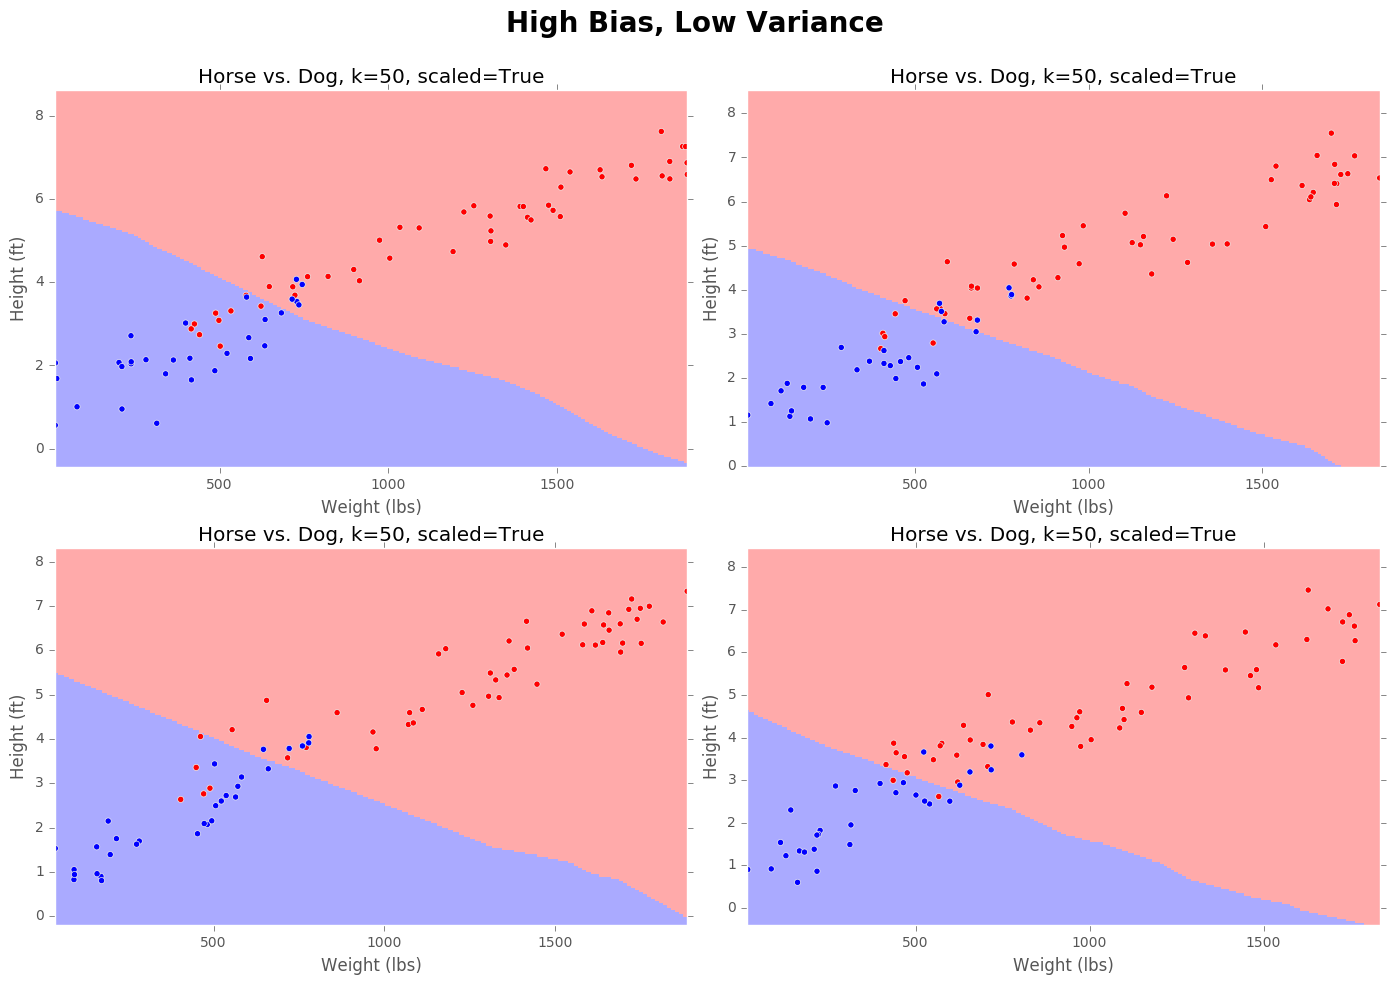

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for sample, ax in zip(samples_from_same_pop, axs.flatten()):
    X = sample[0]
    y = sample[1]
    plot_mult_decision_boundary(ax, X, y, k=50, title=title, xlabel=xlabel, ylabel=ylabel)
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('High Bias, Low Variance', fontsize=20, weight='bold')
plt.show()

## Scaling Could Be Important

What is going on in these plots?

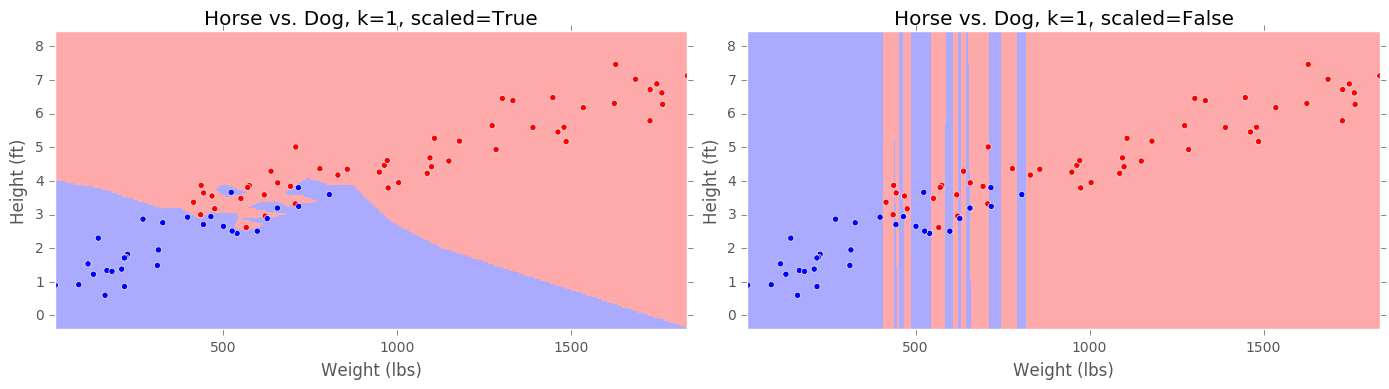

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
                        
plot_mult_decision_boundary(axs[0], X, y, k=1, title=title, xlabel=xlabel, ylabel=ylabel)
plot_mult_decision_boundary(axs[1], X, y, k=1, scaled=False, title=title, xlabel=xlabel, ylabel=ylabel)

plt.tight_layout()
plt.show()

Scaling important for any algorithms that use distance.

## Distance Metrics

A few common distance metrics, but there are many more.

### Manhattan Distance
City blocks, L1

*Manhattan* distance is the distance as measured along axes at right angles:

$$\sum_i |a_i - b_i|$$


### Euclidean Distance

Straight line, L2

*Euclidean* distance is the distance metric you've probably heard of before:

$$ d(\mathbf{a}, \mathbf{b}) = ||\mathbf{a} - \mathbf{b}|| \ = \sqrt{\sum (a_i - b_i)^2} $$

### Cosine Similarity

Angle

*Cosine* similarity is another commonly used distance metric. It's measuring the angle between the two vectors:

$$ d(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{a}||  ||\mathbf{b}||} $$


#### sklearn default is Minkowski (with p=2 which is really just euclidean, p=1 is manhattan)

## Curse of Dimensionality

### Perspective 1: Sample Density

Sampling density is proportional to $$N^\frac{1}{p}$$

where N is the number of samples and p is the number of dimensions.

Let's consider a data set with 100 samples that all have only one feature/predictor. But, you feel that one feature doesn't tell you enough to properly predict anything, so you set out to collect new data. The new data will have ten features/predictors for each sample. How many samples do we need to have an equally dense sample as our original dataset?

#### Original Sample

$$\begin{align}
          density & = N^\frac{1}{p} \\
          & = 100^\frac{1}{1} \\
          & = 100 
\end{align}$$

#### New Sample

$$\begin{align}
          N & = density^ p \\
          &= 100^{10} \\
          &= 100,000,000,000,000,000,000
\end{align}$$

### Perspective 2: Loss of Locality

As we increase dimensionality, we lose the concept of locality and things get infinitely far apart.

For example, in Euclidean distance we must be close in ***all*** dimensions to be considered close.

Close in 2 of 3 dimensions, but far in the 3rd dimension makes the points far apart.

#### Math example

In [25]:
# Make two arbitrary (x, y z) points
p1 = np.array([1, 1, 400])
p2 = np.array([2, 2, 10])

print "Distance in 1-dimension {}".format(np.linalg.norm(p1[0] - p2[0]))
print "Distance in 2-dimensions {}".format(np.linalg.norm(p1[0:2] - p2[0:2]))
print "Distance in 3-dimensions {}".format(np.linalg.norm(p1 - p2))


Distance in 1-dimension 1.0
Distance in 2-dimensions 1.41421356237
Distance in 3-dimensions 390.002564094


#### Real LIfe Analogy: Seattle and Tacoma

* Longitude
* Latitude
* Population
* Elevation
* Number of tech companies
* etc. etc.

## Curse of Dimensionality Analogies

Class discussion: brainstorm some analogies

## Pros and Cons of kNN

Class discussion: what do you think they are? why?

In [26]:
# load answers after class discussion
with open('answers/pc_knn.txt') as f:
    for line in f:
        print line

Pros:

-----

* Training is trivial!

    * Save the data....done.

* Simple to explain.

    * Things that are close are similar.

* Works with any number of classes.

* Easy to add new data.

    * Add it to saved data.

* Few hyperparameters to tune.

    * k

    * distance metric

Cons:

-----

* Slow (and costly) to predict.

    * Have to calculate the distance to every training point

* Bad at high dimensions

    * Curses!

* Categorical features don't work well



## kNN Variants

Here are a few common variants on the kNN algorithm.

### Weighted Voting

<img src="images/weighted_knn.png" width=500 align="left"/>

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

The ith point votes with weight of $$\frac{1}{d_i}$$

### Regression kNN

<img src="images/regression_knn.png" width=500 align="left"/>

Let the k nearest points have distances $$d_1, d_2,..., d_k$$

Let the k nearest points have targets $$t_1, t_2,..., t_k$$

Predict the mean value ***or*** predict a weighted average

## Morning Exercise Objectives [morning-kNN]
Reinforces the following objectives

* **Implement** pseudocode for kNN algorithm
    * Writing a class that implements the kNN algorithm
* **State** common distance metrics used for kNN
    * Writing code that calculates two most common
* **Describe** effect of varying k (num_neigbors)
    * Cross validating to choose k
    * Plotting decision boundary can visualize the effect
* **Explain** importance of scaling for kNN
    * Plotting decision boundary can visualize the effect

## Objectives [afternoon-DT]

* **Explain** one analogy demonstrating intuition of decision tree algorithm
* **Describe** common measures for making splits in a decision tree
    * Classification
    * Regression
* **Demonstrate** calculations to perform a split by hand, given data
* **Draw** graph of impurity function
* **State** difference between how decision tree and regresssion tree make final predictions
* **Demonstrate** concept of recursion and **relate** it to decision trees
* **Implement** pseudocode for decision tree algorithm
* **Analyze** prediction metrics for overfitting
* **Explain** methods for picking "best" tree
* **State** pruning techniques and pros/cons of each
    * Pre-pruning
    * Post-pruning
* **Demonstrate** use of cost penalty for post-pruning
* **Describe** pros/cons of decision tree algorithm

In [27]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)

In [28]:
# Clean up a few things, based on my preferences and making calculating probabilities easier
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)

In [29]:
# Let's look at the data
tennis_df

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
6,overcast,cool,normal,True,1
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1


## How Would You Determine If You Played Tennis?

Class discussion

## Quantifying Our Decisions

### Shannon Entropy

Common measure of impurity

$$H(X) = E[I(X)] = E[log_2(\tfrac{1}{Pr(X)})]$$

$$= -E[log_2(Pr(X))]$$

$$H(X) = - \sum_i Pr_i log_2(Pr_i)$$


### Entropy Graph of Bernoulli Random Variable

<img src="images/entropy_graph.png" width=500 align="left"/>

In [30]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: 1d numpy array
    
    Returns
    -------
    float
    """
    total_samples = y.shape[0]
    summation = 0
    
    for class_i in np.unique(y):
        prob = sum(y == class_i) / float(total_samples)
        summation += prob * np.log2(prob)
    
    return -summation

In [31]:
y = tennis_df['played'].values

print "Entropy of original data set is {}".format(calc_entropy(y))

Entropy of original data set is 0.940285958671


### Information Gain for Entropy

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$


In [32]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: 1d numpy array
        Labels for parent node
    
    y1: 1d numpy array
        Labels for potential child node 1
    
    y2: 1d numpy array
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = float(y.shape[0])
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = child_node.shape[0]
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [33]:
# Let's split on the temperature. I know I wouldn't want to play tennis when it's hot
# Then again, I'm from Arizona so hot means 112 degrees...

y1 = tennis_df[tennis_df['temperature'] == 'hot']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'hot']['played'].values

In [34]:
print "Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy))

Information Gain is 0.0250781735059.


In [35]:
# Not much gain, maybe I really liked playing when the temperature was mild
# Let's try that split

y1 = tennis_df[tennis_df['temperature'] == 'mild']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'mild']['played'].values

In [36]:
print "Information Gain is {0}.".format(calc_info_gain(y, y1, y2, calc_entropy))

Information Gain is 0.00133974240444.


In [37]:
# Still not much headway, let's just try every possible split and see what works
# And also confirm what we used our common sense algorithm we started with

possible_splits = {}
# Get just my features from the dataframe
feature_cols = tennis_df.drop('played', axis=1)

# For a given column, find all the unique possible values
for col in feature_cols:
    col_splits = np.unique(tennis_df[col])
    # For each possible value, split the dataset using that value
    for pos_val in col_splits:
        y1 = tennis_df[tennis_df[col] == pos_val]['played'].values
        y2 = tennis_df[tennis_df[col] != pos_val]['played'].values
        # Calculate the information gain, save it for later
        ig = calc_info_gain(y, y1, y2, calc_entropy)
        key = "{0}: {1}".format(col, pos_val)
        possible_splits[key] = ig

In [38]:
# Print out our results in a pretty way
colname1 = "Col Name: Value"
colname2 = "Information Gain"
print "{0:20} || {1}".format(colname1, colname2)
print "-----------------------------------------"
for k,v in sorted(possible_splits.items(), key=operator.itemgetter(1), reverse=True):
    print "{0:20} || {1}".format(k, v)
    

Col Name: Value      || Information Gain
-----------------------------------------
outlook: overcast    || 0.226000244385
humidity: normal     || 0.151835501362
humidity: high       || 0.151835501362
outlook: sunny       || 0.10224356361
wind: True           || 0.0481270304083
wind: False          || 0.0481270304083
temperature: hot     || 0.0250781735059
temperature: cool    || 0.014956069929
outlook: rainy       || 0.00318485304465
temperature: mild    || 0.00133974240444


In [39]:
# Splitting on overcast gave us the largest info gain
# Let's look at what those child nodes look like and their respective entropies
child_node_left = tennis_df[tennis_df['outlook'] == 'overcast']
print "Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values))
child_node_left

Entropy of left child node is -0.0


,outlook,temperature,humidity,wind,played
2,overcast,hot,high,False,1
6,overcast,cool,normal,True,1
11,overcast,mild,high,True,1
12,overcast,hot,normal,False,1


In [40]:
# Ok, we got a pure node, that makes sense.
# What about the other node?
child_node_right = tennis_df[tennis_df['outlook'] != 'overcast']
print "Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values))
child_node_right

Entropy of right child node is 1.0


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1
13,rainy,mild,high,True,0


Class discussion: why in the world would we want a node that has maximum entropy?

## How would you know how to stop?

Class discussion: When would you stop? Potential problems?

Will get to this soon.

## Other Ways to Calculate Impurity

### Gini Index

This is the default for sci-kit learn trees.

It is a measure of this probability:

* Take a random element from the set.
* Label it randomly according to the distribution of labels in the set.
* What is the probability that it is labeled incorrectly?

$$\text{Gini}(S) = 1 - \sum_{i \in S} Pr_i^2$$

### Information Gain with Gini Index

$$\text{IG}(S, C) = \text{Gini}(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} \text{Gini}(C_i)$$

## Regression Trees

### Splitting Continuous Values

Class discussion: how would you do it?

In [41]:
# load answers after class discussion
with open('answers/regtree.txt') as f:
    for line in f:
        print line

Use variance as your measure of impurity.

Select feature that minimizes the weighted variance across the resulting nodes.



## Predicting

The final predictions of a decision tree and a regression tree are implemented differently:

### Classification

* Majority class in leaf node
* Better to predict probability of label (impure leaf nodes)

### Regression

* Mean of values in leaf node
* Linear Regression (ooo, fancy)
    * Also called *model trees*

## Recursion

Recursion uses the idea of "divide and conquer" to solve problems. It divides a complex problem you are working on into smaller sub-problems that are easily solved, rather than trying to solve the complex problem directly.

Recursive functions split the problem into two cases: the ***base case*** and the ***recursive case***. The function continually loops, calling itself, until it reaches the base case.

* Base case: Stopping criteria, the simplest case that can be solved directly.
    * Have to make sure your base case will actually terminate the loop
* Recursive case: Function that splits the problem into the smaller subproblems.
    * Have to make sure your function is reducing the problem to smaller pieces
    
### Example: Factorial

Are the following three functions the same?

$$ f(x) = \prod_{i=1}^xi $$

$$f(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \leq 1 \\
		xf(x-1) & \mbox otherwise
	\end{array}
\right.
$$

In [42]:
def factorial(x):
    """Recursively calculate x!"""
    # base case is when we get to x=0, which is 0! = 1
    if x <= 1:
        return 1
    # otherwise, recursive case, notice how we are reducing x
    else:
        return x * factorial(x-1)

In [43]:
factorial(3)

6

***Map out on whiteboard***

In [44]:
factorial(25)

15511210043330985984000000L

In [45]:
def power(base, exp):
    """Recursively caclulate base ** exp"""
    # base case is when exp = 0, base ** 0 = 1
    if exp <= 0:
        return 1
    #  otherwise, recursive case, reduce exp
    return base * power(base, exp - 1)

In [46]:
power(3, 4)

81

***Map out on whiteboard***

In [47]:
power(25, 5)

9765625

### You do, fill in the following function

In [48]:
def len_str(str):
    """Recursively determine the length of a string"""
    # base case, when should you stop?  
    # recursive case, how can you reduce your problem?
    pass

In [49]:
#test your function

## DT Pseudocode

Recursive partitioning algorithm

```
function BuildTree:
    # base case, stop building tree
    If every item in the dataset is in the same class
    or there is not feature left to split the data:
        return a leaf node with the class label
    # recursive case, keep splitting stuff
    Else:
        find the best feature and value to split the data
        split the dataset
        create a node
        for each split
            call Build Tree and add the result as a child of the node
        return node
```

## Performance of Decision Trees

Class discussion: what are some problems you forsee with this approach?

## Picking the Best Tree

* Cross validate!
    * Train trees with different parameters, see which performs best on validation set
    * No different than any other model

## Pruning

We call the idea of modifying a decision tree to improve its performance ***pruning***.

There are two approaches: ***pre-pruning*** and ***post-pruning***.

### Pre

Prune as we build the tree, control hyper-parameters

Class discussion: what can we control?

In [51]:
with open('answers/preprune.txt') as f:
    for line in f:
        print line

Common Things to Pre-Prune

--------------------------

* Leaf size: stop splitting when num of samples is small enough

* Tree depth: stop splitting at a certain depth

* Purity: stop splitting if purity of leaf nodes hits certain threshold

* Gain Threshold: stop splitting when info gain fails to meet threshold



### Post

Prune after we build the complete tree

* Merge leaves if doing so decreases test-set error

#### Pseudocode
```
function Prune:
    if either left or right is not a leaf:
        call Prune on that split
    if both left and right are leaf nodes:
        calculate error associated with merging two leaf nodes
        calculate error associated without merging two leaf nodes
        if merging results in lower error:
            merge the leaf nodes
```

## Pros and Cons of Decision Trees

Class discussion: what do you think?

In [52]:
# load answers after class discussion
with open('answers/pc_dt.txt') as f:
    for line in f:
        print line

Pros:

-----

* Flexible

    * Can be used for classification and for regression.

* Interpretable

    * It's just a flowchart.

* Cheap (and Quick) Prediction

    * Follows a flowchart

* Can handle missing values and outliers

* Can handle irrelevant features

Cons:

-----

* Slow (and costly) to train.

    * Has to try every possible split every time.

* Greedy algorithm

    * Local maxima

* Overfits always and forever (if you don't stop it)

* Right-angle decision boundaries only

    * Binary decisions



## The Decision Tree Algorithms

There are some famous variants of the decision tree algorithm:

### ID3

Short for Iterative Dichotomiser 3, the original Decision Tree algorithm developed by Ross Quinlan (who's responsible for a lot of proprietary decision tree algorithms) in the 1980's.

* designed for only categorial features
* splits categorical features completely
* uses entropy and information gain to pick the best split

### CART

Short for Classification and Regression Tree was invented about the same time as ID3 by Breiman, Friedman, Olshen and Stone. The CART algorithm has the following properties:

* handles both categorial and continuous data
* always uses binary splits
* uses gini impurity to pick the best split

Algorithms will be called CART even if they don't follow all of the specifications of the original algorithm.

### C4.5

This is Quinlan's first improvement on the ID3 algorithm. The main improvements are:

* handles continuous data
* implements pruning to reduce overfitting

### C5.0

This is supposedly better, but it's proprietary so we don't have access to the specifics of the improvements.

## Pair Exercise Objectives [afternoon-DT]
Reinforces the following objectives

* **Implement** pseudocode for decision tree algorithm
    * Writing code that implements CART algorithm
* **Explain** one analogy demonstrating intuition of decision tree algorithm
* **Describe** common measures for making splits in a decision tree
    * Classification
        * Writing code to calculate entropy and Gini
* **Demonstrate** concept of recursion and **relate** it to decision trees
    * * Writing code that implements CART algorithm
    
#### Extra Credit 1
* **State** pruning techniques and pros/cons of each
    * Pre-pruning
        * Writing code to implement pre-pruning
    * Post-pruning
        * Writing code to implement post-pruning
* **Demonstrate** use of cost penalty for post-pruning
    * Writing code to implement post-pruning
        
#### Extra Credit 2
* **Describe** common measures for making splits in a decision tree
    * Regression
        * Writing code to implement regression tree